In [2]:
#!/usr/bin/env python
# coding: utf-8

# %% [markdown]
# # Clustering Analysis of Unit Operations
#
# This notebook aggregates multiple batches and their respective runs, processes the unit operations,
# computes embeddings, clusters them, and visualizes the results.
#
# **Enhancements:**
# 1. **Aggregating Multiple Batches and Runs**: The script now supports processing multiple batch folders.
# 2. **Updated Run Identification Logic**: Adjusted to handle run folder names where the run number is at the end (e.g., `corn stover_to_ethanol_(1)`).
#
# **Dependencies:**
# - `networkx`
# - `pandas`
# - `matplotlib`
# - `seaborn`
# - `sentence-transformers`
# - `umap-learn`
# - `scikit-learn`

# %% [markdown]  
# ## Imports and Setup

# %%
import os  
import json
import re
from pathlib import Path
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# For inline plotting in Jupyter
%matplotlib inline

sns.set_style("whitegrid")




In [3]:
# %% [markdown]
# ## Configuration
#
# - **Data Directory**: Specify the root directory containing all batch folders.
# - **Run Folder Pattern**: Define a regex pattern to identify run folders with run numbers at the end.

# Root directory of the project
project_root = Path("..")  # Adjust as necessary based on your project structure

# Directory containing all batch folders
batches_dir = project_root / "data" / "corn_stover_to_ethanol"

# List of batch folder IDs to process
selected_batches = [
    "20241209_000851",
    "20241209_001652",
    "20241209_003530",
    "20241209_003719",
    "20241209_004018",
    "20241210_183610"
]

# Regex pattern to match run folders like 'corn stover_to_ethanol_(1)', 'corn stover_to_ethanol_(2)', etc.
# Can remove this (add to my to-do)
run_folder_pattern = re.compile(r'^corn stover_to_ethanol_\(\d+\)$')

In [4]:
# %% [markdown]
# ## Data Loading: Aggregating Specified Batches and Runs

# %%
# Initialize an empty dictionary to store DAGs
dags = {}

# Iterate through each selected batch folder
for batch_id in selected_batches:
    batch_dir = batches_dir / batch_id
    if batch_dir.exists() and batch_dir.is_dir():
        # print(f"Processing Batch: {batch_id}")
        
        # Iterate through each run folder within the batch
        for run_dir in batch_dir.iterdir():
            if run_dir.is_dir() and run_folder_pattern.match(run_dir.name):
                run_name = run_dir.name
                # Create a unique identifier by combining batch ID and run name
                unique_run_name = f"{batch_id}_{run_name}"
                
                dag_path = run_dir / "v1_DAG.json"
                if dag_path.exists():
                    try:
                        with open(dag_path, "r") as f:
                            dag_data = json.load(f)
                        dags[unique_run_name] = dag_data
                        # print(f" - Loaded DAG for Run: {unique_run_name}")
                    except json.JSONDecodeError as e:
                        print(f"   * Error decoding JSON for {unique_run_name}: {e}")
                else:
                    print(f"   * DAG not found for Run: {unique_run_name}")
    else:
        print(f"Batch folder not found or is not a directory: {batch_id}")

print(f"\nTotal Runs Loaded: {len(dags)}")



Total Runs Loaded: 100


In [5]:

# %% [markdown]
# ## Convert DAGs to NetworkX Graphs

# %%
def dag_to_networkx(dag_data):
    G = nx.DiGraph()
    unit_ops = dag_data.get("unit_operations", {})

    # Add nodes
    for uop_id, uop_data in unit_ops.items():
        G.add_node(uop_id, **uop_data)

    # Add edges based on streams
    streams = dag_data.get("streams", {})
    for stream_id, sdata in streams.items():
        source = sdata['source']
        target = sdata['target']
        # Only add edge if both source and target are unit operations
        if source in unit_ops and target in unit_ops:
            G.add_edge(source, target, **sdata)

    return G

# Create NetworkX graphs from DAGs
graphs = {run_name: dag_to_networkx(dag_data) for run_name, dag_data in dags.items()}

print(f"Total Graphs Created: {len(graphs)}")


Total Graphs Created: 100


In [6]:

# %% [markdown]
# ## Assess Unit Operations Across DAGs for Stability

# %%
unit_op_counts = {}
for run_name, G in graphs.items():
    for node in G.nodes:
        unit_op_counts[node] = unit_op_counts.get(node, 0) + 1

# Convert to a DataFrame to see frequency
uop_df = pd.DataFrame([{'unit_op': k, 'count': v} for k, v in unit_op_counts.items()])
uop_df.sort_values('count', ascending=False, inplace=True)
uop_df.reset_index(drop=True, inplace=True)

# print("Unit Operations Frequency:")
# uop_df


C:\Users\Jesse\AppData\Local\Temp\ipykernel_7036\2238073952.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uop_df, x='unit_op', y='count', palette='viridis')


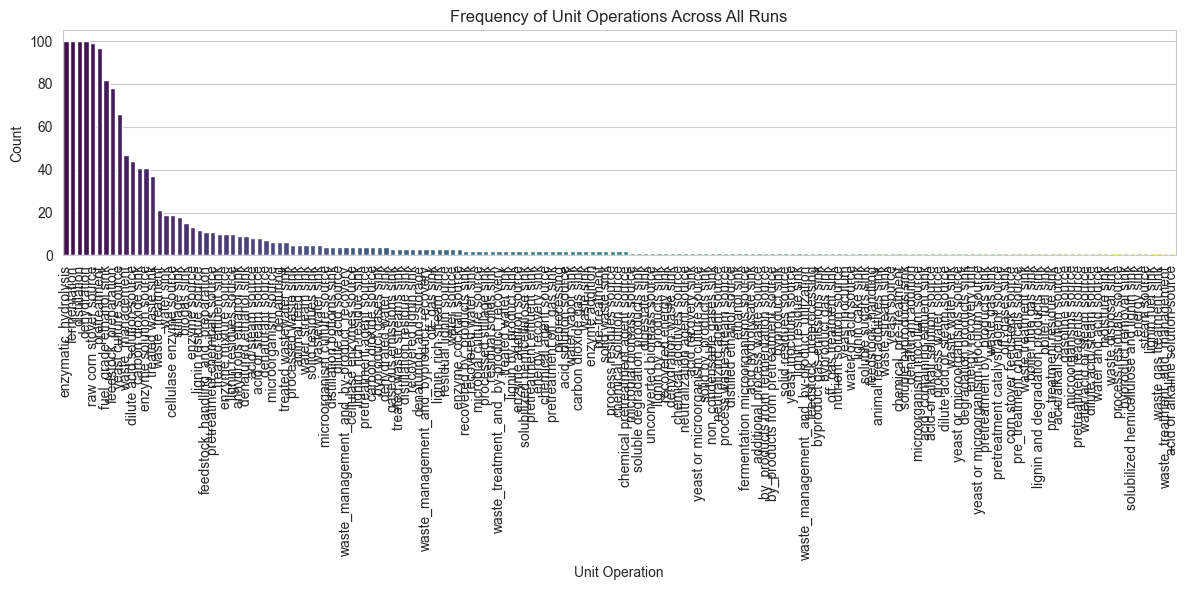

In [7]:

# %% [markdown]
# ## Visualize Frequency of Unit Operations

# %%
plt.figure(figsize=(12, 6))
sns.barplot(data=uop_df, x='unit_op', y='count', palette='viridis')
plt.xticks(rotation=90)
plt.title("Frequency of Unit Operations Across All Runs")
plt.xlabel("Unit Operation")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [8]:

# %% [markdown]
# ## Compute Jaccard Similarity for Edges Between Runs

# %%
from itertools import combinations

def graph_edge_set(G):
    return set(G.edges())

similarities = []
run_pairs = list(combinations(graphs.keys(), 2))
print(f"Computing Jaccard similarity for {len(run_pairs)} run pairs...")

for r1, r2 in run_pairs:
    G1, G2 = graphs[r1], graphs[r2]
    e1, e2 = graph_edge_set(G1), graph_edge_set(G2)
    inter = len(e1.intersection(e2))
    union = len(e1.union(e2))
    jaccard = inter / union if union else 0
    similarities.append({'run1': r1, 'run2': r2, 'jaccard_edge_similarity': jaccard})

sim_df = pd.DataFrame(similarities)
# print("Sample of Jaccard Similarity:")
# sim_df.head()


Computing Jaccard similarity for 4950 run pairs...


In [9]:

# %% [markdown]
# ## Save Analysis Results to CSV

# %%
# Define output directory
output_dir = batches_dir / "analysis_results"
output_dir.mkdir(parents=True, exist_ok=True)

# Save unit operation counts
uop_df.to_csv(output_dir / "analysis_unit_op_counts.csv", index=False)
print(f"Unit operation counts saved to {output_dir / 'analysis_unit_op_counts.csv'}")

# Save graph similarities
sim_df.to_csv(output_dir / "analysis_graph_similarities.csv", index=False)
print(f"Graph similarities saved to {output_dir / 'analysis_graph_similarities.csv'}")


Unit operation counts saved to ..\data\corn_stover_to_ethanol\analysis_results\analysis_unit_op_counts.csv
Graph similarities saved to ..\data\corn_stover_to_ethanol\analysis_results\analysis_graph_similarities.csv


In [10]:

# %% [markdown]
# ## Embedding and Clustering Analysis
#
# The following sections perform embedding-based clustering of unit operations to assess semantic consistency and stability across runs.

# %% [markdown]
# ### Extract Unit Operations and Prepare Text for Embedding

# %%
# Collect unit operations from all runs
unit_ops_data = []  # Stores dicts: { 'run': run_name, 'unit_op_id': node_id, 'text': ... }

for run_name, G in graphs.items():
    for node, data in G.nodes(data=True):
        # Combine name and description for embedding
        name = data.get('name', 'Unnamed Unit Operation')
        description = data.get('description', '')
        text = f"{name}: {description}"
        unit_ops_data.append({
            'run': run_name,
            'unit_op_id': node,
            'text': text
        })

unit_ops_df = pd.DataFrame(unit_ops_data)
# print("Number of unit operations across all runs:", len(unit_ops_df))
# unit_ops_df.head()


In [11]:

# %% [markdown]
# ### Compute Embeddings

# %%
# Initialize the Sentence Transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
embeddings = model.encode(unit_ops_df['text'].tolist(), convert_to_numpy=True)

print("Embeddings shape:", embeddings.shape)


Embeddings shape: (1490, 384)


In [12]:

# %% [markdown]
# ### Clustering with K-Means

# %%
# Define number of clusters
n_clusters = 10  # Adjust as needed

# Initialize and fit K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
labels = kmeans.fit_predict(embeddings)

# Assign cluster labels to the DataFrame
unit_ops_df['cluster_label'] = labels
# unit_ops_df.head()


In [13]:

# %% [markdown]
# ### Dimensionality Reduction with UMAP

# %%
# Initialize UMAP reducer
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)

# Fit and transform embeddings
reduced_embeddings = reducer.fit_transform(embeddings)

# Create a DataFrame for reduced dimensions
reduced_df = pd.DataFrame({
    'x': reduced_embeddings[:, 0],
    'y': reduced_embeddings[:, 1],
    'cluster': labels,
    'run': unit_ops_df['run'],
    'unit_op_id': unit_ops_df['unit_op_id'],
    'text': unit_ops_df['text']
})

# Display a sample of the reduced DataFrame
# reduced_df.head()


c:\Users\Jesse\anaconda3\envs\tea_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [14]:
# %% [markdown]
# ### Assess Cluster Compactness: Elements Within a Dynamic Radius (Median + IQR)

# %%
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, HTML

# Function to extract title and description
def extract_title(text):
    return text.split(':')[0] if ':' in text else text

def extract_title_description(text):
    parts = text.split(':', 1)
    if len(parts) == 2:
        return parts[0].strip(), parts[1].strip()
    else:
        return parts[0].strip(), ""

# Add a new column 'title' by extracting the part before the colon in 'text'
reduced_df['title'] = reduced_df['text'].apply(extract_title)

# Create a DataFrame to store representative points for each cluster
representatives = []
for cluster_num in range(n_clusters):
    cluster_data = reduced_df[reduced_df['cluster'] == cluster_num]
    if cluster_data.empty:
        continue
    representative = cluster_data.iloc[0]
    title = representative['title']
    representatives.append({
        'cluster': cluster_num,
        'x': representative['x'],
        'y': representative['y'],
        'title': title
    })
representatives_df = pd.DataFrame(representatives)
print("\nRepresentative Elements for Each Cluster:")
print(representatives_df)

# Define the fixed radius based on median + 1 IQR
cluster_compactness = []
for cluster_num in range(n_clusters):
    cluster_data = reduced_df[reduced_df['cluster'] == cluster_num]
    if cluster_data.empty:
        print(f"Cluster {cluster_num} is empty. Skipping...")
        continue
    centroid = cluster_data[['x', 'y']].mean().values
    distances = np.linalg.norm(cluster_data[['x', 'y']].values - centroid, axis=1)
    median_distance = np.median(distances)
    q1 = np.percentile(distances, 25)
    q3 = np.percentile(distances, 75)
    iqr = q3 - q1
    radius = median_distance + 1 * iqr
    within_radius = np.sum(distances <= radius)
    representative_text = cluster_data.iloc[0]['text']
    representative_title, representative_description = extract_title_description(representative_text)
    cluster_compactness.append({
        'Cluster #': cluster_num,
        'Representative Name': representative_title,
        'Representative Description': representative_description,
        'Total Elements': len(cluster_data),
        'Elements Within Radius': within_radius,
        'Radius': radius
    })
compactness_df = pd.DataFrame(cluster_compactness)
print("\nCluster Compactness Summary:")
print(compactness_df)

# Create the interactive scatter plot using Plotly Express
fig = px.scatter(
    reduced_df,
    x='x',
    y='y',
    color=reduced_df['cluster'].astype(str),
    hover_data={
        'cluster': True,
        'title': True,
        'x': False,
        'y': False
    },
    labels={
        'x': 'UMAP-1',
        'y': 'UMAP-2',
        'color': 'Cluster'
    },
    title="UMAP Projection of Unit Operation Embeddings (Clustered)",
    width=900,
    height=700
)

# Update layout for better aesthetics
fig.update_layout(
    legend_title_text='Cluster',
    legend=dict(
        title_font_size=14,
        font_size=12,
        itemsizing='constant'
    )
)

# Add annotations for each representative point
for _, row in representatives_df.iterrows():
    fig.add_trace(
        go.Scatter(
            x=[row['x']],
            y=[row['y']],
            mode='markers+text',
            marker=dict(
                color='black',
                size=12,
                symbol='star'
            ),
            text=[f"Cluster {int(row['cluster'])}: {row['title']}"],
            textposition='top center',
            showlegend=False
        )
    )

# Optionally, add circles representing the radius
for idx, row in compactness_df.iterrows():
    cluster_num = row['Cluster #']
    cluster_data = reduced_df[reduced_df['cluster'] == cluster_num]
    centroid = cluster_data[['x', 'y']].mean().values
    radius = row['Radius']
    fig.add_shape(
        type="circle",
        xref="x",
        yref="y",
        x0=centroid[0] - radius,
        y0=centroid[1] - radius,
        x1=centroid[0] + radius,
        y1=centroid[1] + radius,
        line=dict(
            color="Red",
            width=2
        ),
        opacity=0.2,
        name=f'Radius {cluster_num}'
    )

fig.show()

# Display the Cluster Compactness Summary Table
display(HTML("<h3>Cluster Compactness Summary:</h3>"))
display(HTML(compactness_df.to_html(index=False)))

# Save Cluster Compactness Summary to CSV
compactness_df.to_csv(output_dir / f"cluster_compactness_summary_dynamic_radius.csv", index=False)
print(f"Cluster compactness summary saved to {output_dir / 'cluster_compactness_summary_dynamic_radius.csv'}")

fig.write_html("corn_stover_to_ethanol_clustering.html", include_plotlyjs=True, full_html=True)



Representative Elements for Each Cluster:
   cluster          x          y                          title
0        0  11.213507  11.131640  Pretreatment Chemicals Source
1        1   2.756198  -8.083032        Fuel-Grade Ethanol Sink
2        2   5.485927  20.443024             Feedstock Handling
3        3  -0.314611  19.145117                   Fermentation
4        4  15.543632  22.492493   Corn Stover Feedstock Source
5        5  27.759911   6.362771           Enzymatic Hydrolysis
6        6   8.882739  -2.583731                 Off-gases Sink
7        7  16.316736   3.314941                Waste Treatment
8        8  -6.821756   6.609378                   Distillation
9        9   9.795526   0.630856             Treated Waste Sink

Cluster Compactness Summary:
   Cluster #            Representative Name  \
0          0  Pretreatment Chemicals Source   
1          1        Fuel-Grade Ethanol Sink   
2          2             Feedstock Handling   
3          3                   Ferm

Cluster #,Representative Name,Representative Description,Total Elements,Elements Within Radius,Radius
0,Pretreatment Chemicals Source,"This unit operation serves as a source for the Pretreatment Chemicals stream, which includes dilute acids and alkalis. These chemicals are essential for the pretreatment process, as they help to disrupt the lignin structure and partially hydrolyze hemicellulose in the biomass feedstock. This step is crucial for enhancing the accessibility of cellulose for subsequent enzymatic hydrolysis, ultimately improving the efficiency of the overall conversion process to produce ethanol.",107,84,1.262700
1,Fuel-Grade Ethanol Sink,"This unit operation serves as the final sink for the Fuel-Grade Ethanol stream, which is produced after the dehydration of crude ethanol. It is designed to receive the high-purity ethanol, ensuring that it meets the required specifications for blending with gasoline or for use in various industrial applications. The unit operation guarantees the safe storage and handling of the ethanol, maintaining its quality and preventing contamination.",134,116,7.834498
2,Feedstock Handling,"The corn stover, which is a lignocellulosic biomass, is delivered to the processing facility. It is first subjected to size reduction to increase the surface area for subsequent processing steps. This involves mechanical operations such as chopping, grinding, or milling. The reduced-size feedstock is then conveyed to storage silos, ensuring a steady supply for continuous processing.",193,167,3.916672
3,Fermentation,The hydrolysate is transferred to fermentation tanks where yeast or other microorganisms are added to convert the fermentable sugars into ethanol and carbon dioxide. This biological process is carried out under anaerobic conditions. The choice of microorganism and fermentation conditions are optimized to maximize ethanol yield and productivity.,191,191,15.888586
4,Corn Stover Feedstock Source,"This unit operation serves as the source for the Corn Stover Feedstock stream, which is raw corn stover delivered to the facility. The feedstock consists of a complex mixture of cellulose (35-40%), hemicellulose (25-30%), lignin (15-20%), ash (5-10%), and moisture (5-10%). It is a lignocellulosic biomass that typically requires pretreatment to break down cellulose and hemicellulose into fermentable sugars for further processing in the ethanol production pathway.",101,98,0.747396
5,Enzymatic Hydrolysis,"The pretreated biomass is subjected to enzymatic hydrolysis, where cellulase enzymes are added to convert cellulose into fermentable sugars, primarily glucose. This step is critical for maximizing sugar yield, which directly impacts ethanol production efficiency. The reaction is typically carried out in large stirred-tank reactors to ensure thorough mixing and enzyme contact with the substrate.",195,168,13.753284
6,Off-gases Sink,"This unit operation serves as a sink for the off-gases generated during the pretreatment process. It is designed to capture and manage gaseous byproducts, primarily consisting of carbon dioxide and volatile compounds. The off-gases may be directed to a waste treatment facility for further processing or utilized in energy recovery systems, ensuring minimal environmental impact and compliance with emission regulations.",85,83,4.792063
7,Waste Treatment,"The stillage and other waste streams from the process are treated to recover valuable byproducts and minimize environmental impact. This may involve anaerobic digestion to produce biogas, or further processing to recover lignin and other components for use as animal feed or energy production.",124,110,4.887430
8,Distillation,"The fermentation broth is subjected to distillation to separate ethanol from water and other components. This involves heating the mixture to vaporize ethanol, which is then condensed and collected as a concentrated product. Multiple distillation columns may be used to achieve the desired ethanol purity.",210,20

Cluster compactness summary saved to ..\data\corn_stover_to_ethanol\analysis_results\cluster_compactness_summary_dynamic_radius.csv


In [15]:

# %% [markdown]
# ### Investigating Clusters
#
# Display sample unit operations from each cluster to understand their characteristics.

# %%
for c in range(n_clusters):
    cluster_ops = unit_ops_df[unit_ops_df['cluster_label'] == c]
    print(f"Cluster {c}:")
    # Print a few example unit ops from this cluster
    for idx, row in cluster_ops.head(5).iterrows():
        print(" -", row['text'])
    print("\n")


Cluster 0:
 - Pretreatment Chemicals Source: This unit operation serves as a source for the Pretreatment Chemicals stream, which includes dilute acids and alkalis. These chemicals are essential for the pretreatment process, as they help to disrupt the lignin structure and partially hydrolyze hemicellulose in the biomass feedstock. This step is crucial for enhancing the accessibility of cellulose for subsequent enzymatic hydrolysis, ultimately improving the efficiency of the overall conversion process to produce ethanol.
 - Pretreatment Catalyst/Agent Source: This unit operation serves as a source for the Pretreatment Catalyst/Agent stream, which includes various chemical agents such as dilute acids, steam, and alkaline solutions. These agents are essential for the pretreatment process, as they facilitate the breakdown of the lignocellulosic structure in the biomass, enabling the subsequent enzymatic hydrolysis and fermentation stages to convert the biomass into fermentable sugars and u

In [16]:

# %% [markdown]
# ## Save Clustering Results

# %%
# Save cluster assignments
unit_ops_df.to_csv(output_dir / "unit_ops_clusters.csv", index=False)
print(f"Clustering results saved to {output_dir / 'unit_ops_clusters.csv'}.")


Clustering results saved to ..\data\corn_stover_to_ethanol\analysis_results\unit_ops_clusters.csv.


In [17]:

# %% [markdown]
# ## Summary
#
# - **Aggregated Data**: Successfully aggregated multiple batches and their respective runs.
# - **Unique Run Identification**: Each run is uniquely identified by combining the batch ID and run name.
# - **Clustering Analysis**: Performed embedding-based clustering to assess the semantic consistency of unit operations across runs.
# - **Visualization**: Visualized clusters using UMAP for dimensionality reduction.
#
# **Next Steps:**
# - Incorporate validated data for operational parameters.
# - Explore alternative clustering algorithms (e.g., HDBSCAN) for potentially better clustering performance.
# - Analyze clusters to identify common patterns and outliers in unit operations.

